<a href="https://colab.research.google.com/github/dgiri4132/pairs_trading_strategy-zscore/blob/main/Pairs_trading_Stratedy_using_zscore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import yfinance as yf
import pandas as pd
def get_company_name(ticker):
  try:
    return yf.Ticker(ticker).info.get('shortName')
  except:
    return None
option_for_index={'S&P500':'^GSPC','NASDAQ-100':'^NDX','Dow Jones':'^DJI','FTSE 100':'FTSE','Nikkei 225':'^N225','DAX':'^GDAXI','CAC 40':'^FCHI'}
while True:
  chosen_index_key=input(f"Choose anyone of the index from indexes below:{','.join(option_for_index.keys())} ").strip()
  if chosen_index_key in option_for_index:
    chosen_index = option_for_index[chosen_index_key]
    break
  else:
    print('Invalid index. Please try again.')
def index_tickers(chosen_index):
  try:
    if chosen_index=="^GSPC":
      df = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
      return df['Symbol'].tolist()
    elif chosen_index=='^NDX':
      df=pd.read_html('https://en.wikipedia.org/wiki/NASDAQ-100')[4]
      return df['Ticker'].tolist()
    elif chosen_index=='^DJI':
      df=pd.read_html('https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average')[2]
      return df['Symbol'].tolist()
    elif chosen_index=='FTSE':
      df=pd.read_html('https://en.wikipedia.org/wiki/FTSE_100_Index')[4]
      return df['EPIC'].tolist()
    elif chosen_index=='^N225':
      df=pd.read_html('https://en.wikipedia.org/wiki/Nikkei_225')[2]
      return df['Ticker'].tolist()
    elif chosen_index=='^GDAXI':
      df=pd.read_html('https://en.wikipedia.org/wiki/DAX')[2]
      return df['Ticker Symbol'].tolist()
    elif chosen_index=='^FCHI':
      df=pd.read_html('https://en.wikipedia.org/wiki/CAC_40')[1]
      return df['Ticker'].tolist()
    else:
      print('Index not recognized or supported')
      return None
  except Exception as e:
    print(f'Error loading tickers for {chosen_index}:{e}')
    return None
tickers=index_tickers(chosen_index)
tickers=[t.replace('.','-')for t in tickers]
start_date=input('Enter start date(yyyy-mm-dd): ').strip()
end_date=input('Enter end date(yyyy-mm-dd): ').strip()
def data_download(tickers,start_date,end_date):
  data=yf.download(tickers,start=start_date,end=end_date,auto_adjust=False)['Adj Close']
  if isinstance(data.columns,pd.MultiIndex):
    data=data['Adj Close'].dropna(axis=1, how='all')
  else:
    data=data.dropna()
  return data.dropna(axis=1, how='any')
data=data_download(tickers,start_date,end_date)
print(f"{len(data.columns)} tickers with valid data out of {len(tickers)}")
if data.shape[1]<3:
  print('Not enough Valid stocks to compute pairwise correlations.')
  exit()
returns=data.pct_change().dropna()
correlation_matrix=returns.corr()
unstacked_corr=correlation_matrix.unstack()
filtered_pairs=unstacked_corr[unstacked_corr<1]
company_names={ticker: get_company_name(ticker) for ticker in data.columns}
filtered_pairs=filtered_pairs[filtered_pairs.index.map(lambda x: company_names.get(x[0]) != company_names.get(x[1]))]
unique_pairs=filtered_pairs.drop_duplicates()
num_pairs=int(input('Enter the number of top correlated pairs to analyze: ').strip())
top_pairs=unique_pairs.sort_values(ascending=False).head(num_pairs)
if len(top_pairs)==0:
  print('No strong correlations found. Try a different index or time range')
elif len(top_pairs)==1:
  print('Only one pair found. Procceding with the limited data. ')
else:
  print(f'found {len(top_pairs)} top correlated pairs: ')
  print(top_pairs)

Choose anyone of the index from indexes below:S&P500,NASDAQ-100,Dow Jones,FTSE 100,Nikkei 225,DAX,CAC 40 s&P500
Invalid index. Please try again.
Choose anyone of the index from indexes below:S&P500,NASDAQ-100,Dow Jones,FTSE 100,Nikkei 225,DAX,CAC 40 1
Invalid index. Please try again.
Choose anyone of the index from indexes below:S&P500,NASDAQ-100,Dow Jones,FTSE 100,Nikkei 225,DAX,CAC 40 S&P500
Enter start date(yyyy-mm-dd): 2024-11-01
Enter end date(yyyy-mm-dd): 2025-06-01


[*********************100%***********************]  503 of 503 completed


503 tickers with valid data out of 503
Enter the number of top correlated pairs to analyze: 3
found 3 top correlated pairs: 
Ticker  Ticker
CVX     HES       0.980646
AVB     EQR       0.962612
MTB     RF        0.958475
dtype: float64


Enter the z-score threshold(the default is (+/-)1): 0.05
Final few signals to buy or sell for CVX and HES:
Date
2025-05-23    0.0
2025-05-27    1.0
2025-05-28    1.0
2025-05-29    1.0
2025-05-30    1.0
dtype: float64
Final return from strategy on CVX-HES:1.04
Sharpe Ratio of strategy on CVX-HES:0.82


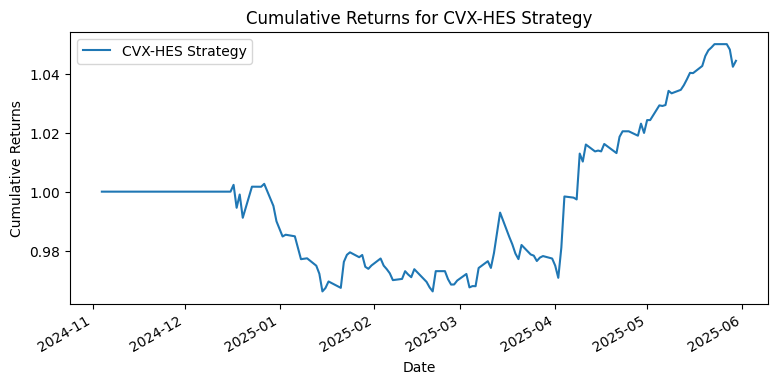

KeyboardInterrupt: Interrupted by user

In [8]:
import matplotlib.pyplot as plt
import numpy as np
def calculate_zscore(spread,window=30):
  rolling_mean=spread.rolling(window=window).mean()
  rolling_std=spread.rolling(window=window).std()
  zscore=(spread-rolling_mean)/rolling_std
  return zscore
def signals(zscore, threshold=1):
  signal=pd.Series(index=zscore.index,dtype='float64')
  signal[zscore>threshold]=-1
  signal[zscore<-threshold]=1
  signal[(zscore<=threshold)&(zscore>=-threshold)]=0
  return signal.ffill().fillna(0)
for i in top_pairs.index:
  stock_1,stock_2=i
  stock_1_norm=data[stock_1]/data[stock_1].iloc[0]
  stock_2_norm=data[stock_2]/data[stock_2].iloc[0]
  spread=stock_1_norm-stock_2_norm
  zscore=calculate_zscore(spread,window=30)
  threshold=float(input(f'Enter the z-score threshold(the default is (+/-)1): ').strip())
  signals_df=signals(zscore, threshold)
  print(f'Final few signals to buy or sell for {stock_1} and {stock_2}:')
  print(signals_df.tail(5))
  #Backtesting according to the signal
  spread_returns=returns[stock_1]-returns[stock_2]
  strategy_returns=signals_df.shift(1)*spread_returns
  cumilative_returns=(1+strategy_returns).cumprod()
  print(f'Final return from strategy on {stock_1}-{stock_2}:{cumilative_returns.iloc[-1]:.2f}')
  rf_daily=0.03/252
  excess_returns=strategy_returns-rf_daily
  if excess_returns.std()!=0:
    sharpe_ratio=excess_returns.mean()/excess_returns.std()*np.sqrt(252)
  else:
    sharpe_ratio=np.nan
  print(f'Sharpe Ratio of strategy on {stock_1}-{stock_2}:{sharpe_ratio:.2f}')
  plt.figure(figsize=(9,4))
  cumilative_returns.plot(label=f'{stock_1}-{stock_2} Strategy')
  plt.title(f'Cumulative Returns for {stock_1}-{stock_2} Strategy')
  plt.xlabel('Date')
  plt.ylabel('Cumulative Returns')
  plt.legend()
  plt.show()


In [ ]:
!git init
!git config --global user.email "darshangiri785@gmail.com"
!git config --global user.name "dgiri4132"


Reinitialized existing Git repository in /content/.git/


In [ ]:
!git remote add origin https://github.com/dgiri4132/pairs_trading_strategy-zscore.git
!git branch -M main
!git add .
!git commit -m "Initial commit for pairs trading strategy using z-score"
!git push -u origin main


[main (root-commit) 9aa3adc] Initial commit for pairs trading strategy using z-score
 21 files changed, 51025 insertions(+)
 create mode 100644 .config/.last_opt_in_prompt.yaml
 create mode 100644 .config/.last_survey_prompt.yaml
 create mode 100644 .config/.last_update_check.json
 create mode 100644 .config/active_config
 create mode 100644 .config/config_sentinel
 create mode 100644 .config/configurations/config_default
 create mode 100644 .config/default_configs.db
 create mode 100644 .config/gce
 create mode 100644 .config/hidden_gcloud_config_universe_descriptor_data_cache_configs.db
 create mode 100644 .config/logs/2025.06.11/13.36.48.453813.log
 create mode 100644 .config/logs/2025.06.11/13.37.08.919149.log
 create mode 100644 .config/logs/2025.06.11/13.37.17.609931.log
 create mode 100644 .config/logs/2025.06.11/13.37.18.763091.log
 create mode 100644 .config/logs/2025.06.11/13.37.27.125319.log
 create mode 100644 .config/logs/2025.06.11/13.37.27.755669.log
 create mode 100755 